In [60]:
import tensorflow as tf
from keras import layers, Model
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tensorflow.python.framework.ops import enable_eager_execution
enable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.reset_memory_stats(gpu, True)

tf.config.run_functions_eagerly(True)

from keras.callbacks import Callback
from keras.utils import img_to_array, array_to_img
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, ConvLSTM1D, LSTM, AveragePooling1D

from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model

c = pd.read_csv('../../Visualizations/color.csv')['color']

In [3]:
my_data = pd.read_csv('HarrisCounty/ForGAN/JulAug.csv')
ds_w = []
ds_e = []
for c in my_data.columns:
    if 'weekday' in c:
        last = my_data[c].values[-1]
        ds_w.append(np.concatenate([my_data[c].values, [last, last, last, last]]).reshape([10, 10]))
    else:
        last = my_data[c].values[-1]
        ds_e.append(np.concatenate([my_data[c].values, [last, last, last, last]]).reshape([10, 10]))

max_w =  np.max(ds_w)
max_e = np.max(ds_e)
ds_w = np.divide(ds_w, 1.1 * max_w)
ds_e = np.divide(ds_e, 1.1 * max_e)
ds_w = tf.data.Dataset.from_tensor_slices(ds_w)
ds_e = tf.data.Dataset.from_tensor_slices(ds_e)

### Prepare data to feed into GAN

In [4]:
batch_size = 15
ds_w = ds_w.cache()
ds_w = ds_w.shuffle(1000)
ds_w = ds_w.batch(batch_size)
ds_w = ds_w.prefetch(64)

## Generator

In [52]:
g_relu = 0.2
def build_generator():
    model = Sequential()
    # Takes a random values, reshapes it to 8*6
    model.add(Dense(5*5*batch_size, input_dim=batch_size))
    model.add(LeakyReLU(g_relu))
    model.add(Reshape((5, 5, batch_size)))

    model.add(UpSampling2D())
    model.add(LeakyReLU(g_relu))

    model.add(UpSampling2D())
    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))
    # model.add(AveragePooling1D(pool_size=2, strides=2, padding='same'))

    model.add(Conv2D(batch_size, 3, strides=2, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    return model
generator = build_generator()
generator.summary()
# series = generator.predict(np.random.randn(4, 6, 1))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 375)               6000      
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 375)               0         
                                                                 
 reshape_7 (Reshape)         (None, 5, 5, 15)          0         
                                                                 
 up_sampling2d_14 (UpSamplin  (None, 10, 10, 15)       0         
 g2D)                                                            
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 10, 10, 15)        0         
                                                                 
 up_sampling2d_15 (UpSamplin  (None, 20, 20, 15)       0         
 g2D)                                                

## Discriminator

In [54]:
d_relu = 0.2
d_dropout = 0.2
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32, 3, input_shape=(10, 10, 1)))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Conv2D(64, 3))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Conv2D(128, 3))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Flatten())
    model.add(Dropout(d_dropout))
    model.add(Dense(1, activation='sigmoid'))
    # 1: fake series, 0: real series

    return model
discriminator = build_discriminator()
discriminator.summary()
# Single prediction needs np.expand_dims(series[0], 0)
# discriminator.predict(np.expand_dims(series[0], 0))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 8, 8, 32)          320       
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 8, 8, 32)          0         
                                                                 
 dropout_25 (Dropout)        (None, 8, 8, 32)          0         
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 8, 8, 32)          0         
                                                                 
 dropout_26 (Dropout)        (None, 8, 8, 32)          0         
                                                                 
 conv2d_44 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 6, 6, 64)        

In [55]:
g_a, d_a = 0.0001, 0.00001
g_opt = Adam(learning_rate=g_a)
d_opt = Adam(learning_rate=d_a)  # Does not learn too fast
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
class LoadGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compilee(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_series = batch
        fake_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images
            yhat_real = self.discriminator(real_series, training=True)
            yhat_fake = self.discriminator(fake_series, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake series
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)


            # pass through and add some noise to the outputs
            noise_real = 0.45*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.45*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Generator training
        with tf.GradientTape() as g_tape:
            # generate same new images
            gen_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_series, training=False)

            # calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
loadgan = LoadGAN(generator, discriminator)
loadgan.compilee(g_opt, d_opt, g_loss, d_loss)

#### Call Back

In [56]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=batch_size):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vector = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_series = self.model.generator(random_latent_vector)
        generated_series *= max_w
        generated_series.numpy()
        for i in range(self.num_img):
            serie = array_to_img(generated_series[i])
            #serie.save(os.path.join('series', f'generated_img_{epoch}_{i}.png'))

#### Train

In [57]:
hist = loadgan.fit(ds_w, epochs=1000, callbacks=[ModelMonitor()])

Epoch 1/1000
13/13 [==============================] - 2s 176ms/step - d_loss: 0.6882 - g_loss: 0.7073
Epoch 2/1000
13/13 [==============================] - 3s 217ms/step - d_loss: 0.6783 - g_loss: 0.7229
Epoch 3/1000
13/13 [==============================] - 2s 188ms/step - d_loss: 0.6756 - g_loss: 0.7353
Epoch 4/1000
13/13 [==============================] - 3s 194ms/step - d_loss: 0.6724 - g_loss: 0.7445
Epoch 5/1000
13/13 [==============================] - 3s 206ms/step - d_loss: 0.6735 - g_loss: 0.7486
Epoch 6/1000
13/13 [==============================] - 3s 210ms/step - d_loss: 0.6833 - g_loss: 0.7419
Epoch 7/1000
13/13 [==============================] - 3s 210ms/step - d_loss: 0.6910 - g_loss: 0.7289
Epoch 8/1000
13/13 [==============================] - 3s 210ms/step - d_loss: 0.7005 - g_loss: 0.7148
Epoch 9/1000
13/13 [==============================] - 3s 209ms/step - d_loss: 0.7033 - g_loss: 0.7075
Epoch 10/1000
13/13 [==============================] - 3s 212ms/step - d_loss: 0.7

1/1 [==============================] - 0s 60ms/step


C:\Users\Feri\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


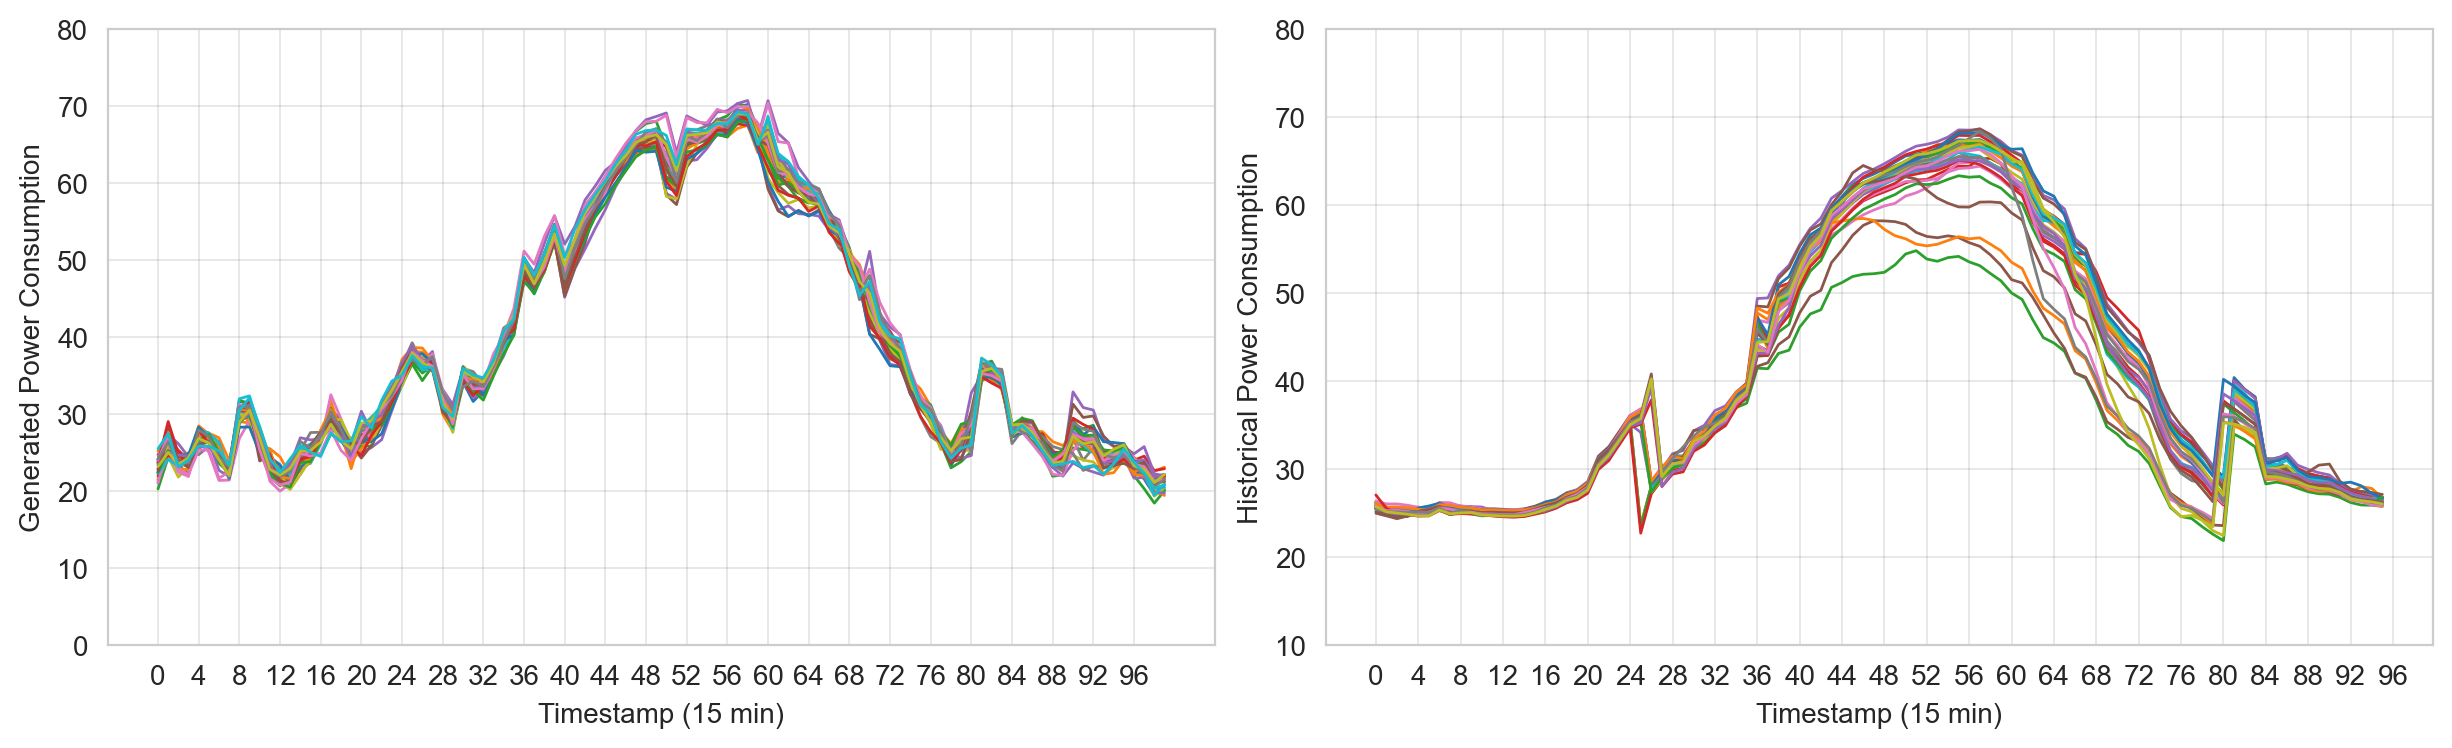

In [66]:
normal_noise = tf.random.normal((30, batch_size, 1))
series = generator.predict(normal_noise)
resolution = 100
ticks = []
for i in range(resolution):
    if i%4 == 0:
        ticks.append(i)

fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
for s in series:
    ax[0].plot(range(resolution), np.multiply(s.reshape([resolution]), max_w), linewidth=1)
ax[0].set_ylim([0, 80])
ax[0].set_xlabel('Timestamp (15 min)')
ax[0].set_ylabel('Generated Power Consumption')
ax[0].set_xticks(ticks, ticks)
ax[0].grid(color='#666362', linestyle='-', linewidth=0.1)

ax[1].plot(my_data[[c for c in my_data.columns[:30] if 'weekday' in c]], linewidth=1)
ax[1].set_ylim([10, 80])
ax[1].set_xlabel('Timestamp (15 min)')
ax[1].set_ylabel('Historical Power Consumption')
ax[1].set_xticks(ticks, ticks)
ax[1].grid(color='#666362', linestyle='-', linewidth=0.1)
plt.subplots_adjust(wspace=0.1)

plt.savefig('HarrisCounty/IMG/JanFeb-weekday.jpg', bbox_inches='tight')

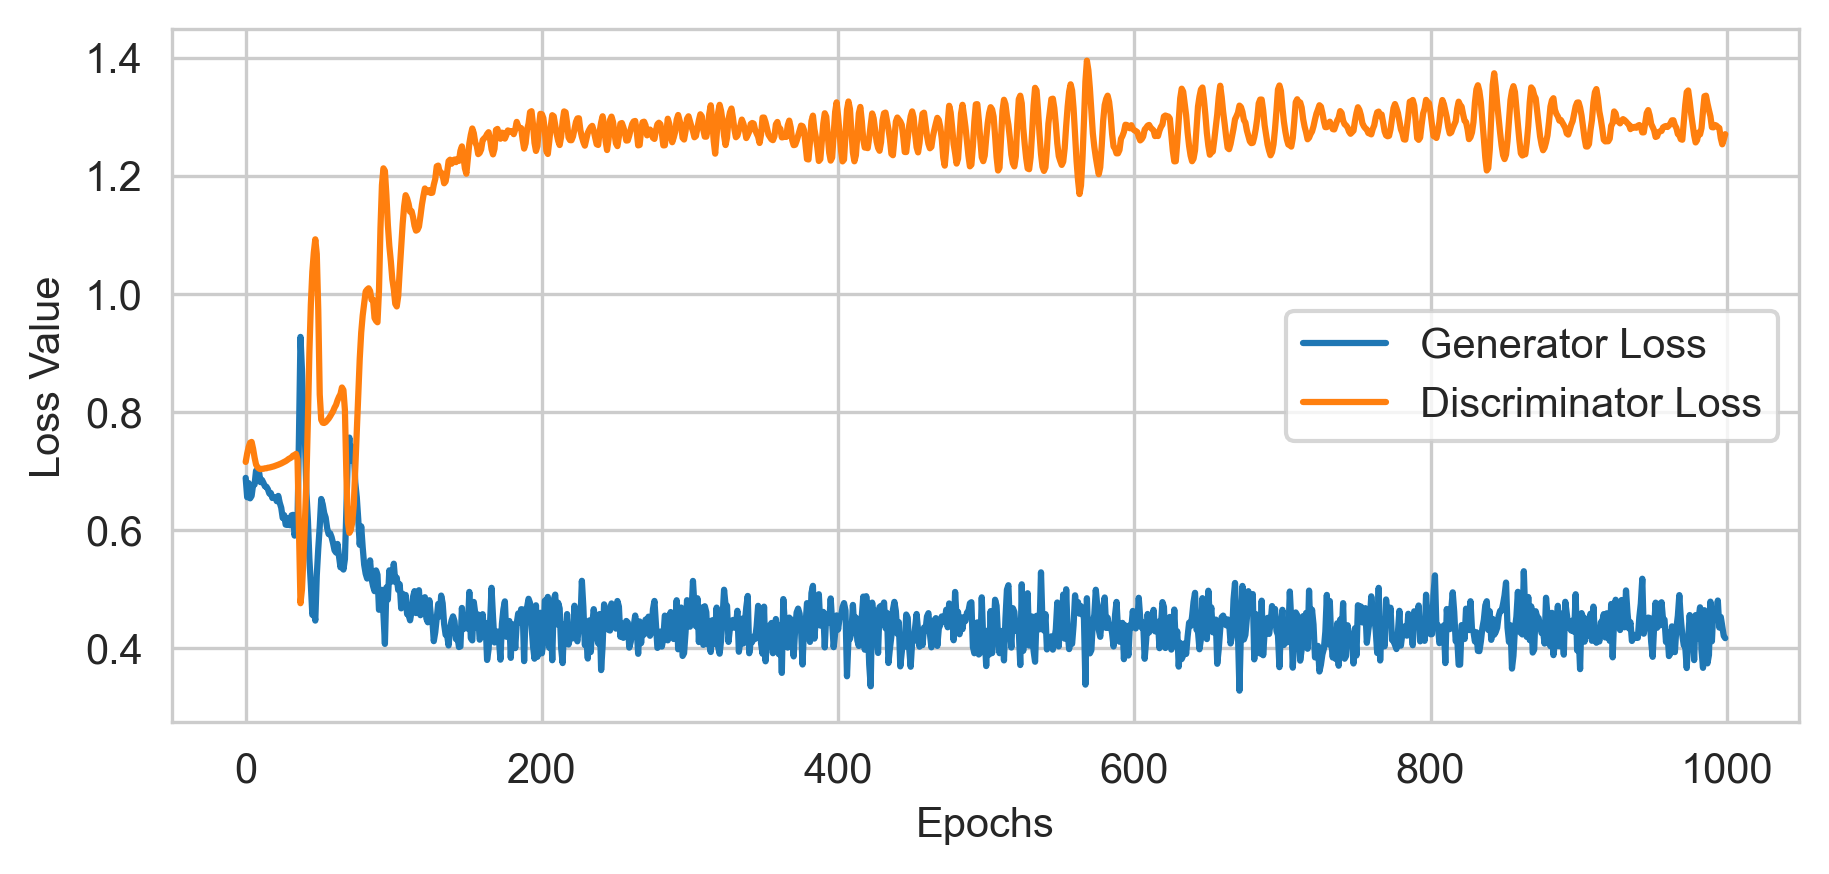

In [65]:
plt.figure(figsize=(7, 3), dpi=300)
plt.plot(hist.history['d_loss'], label='Generator Loss')
plt.plot(hist.history['g_loss'], label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.savefig('HarrisCounty/IMG/JanFeb-weekday-loss.jpg', bbox_inches='tight')

### Save models

In [67]:
generator.save('HarrisCounty/GAN Models/generator-JanFeb-weekday.h5')
discriminator.save('HarrisCounty/GAN Models/discriminator-JanFeb-weekday.h5')